# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [4]:
X_train = np.loadtxt("./datasets/X_train.txt")
y_train = np.loadtxt("./datasets/y_train.txt").astype(int)

X_test = np.loadtxt("./datasets/X_test.txt")
y_test = np.loadtxt("./datasets/y_test.txt").astype(int)

In [5]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [6]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [7]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [8]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [10]:
pca = PCA(n_components=0.9, random_state=17)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

In [11]:
print(pca.n_components_)

65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

In [12]:
print(int(pca.explained_variance_ratio_[0] * 100))

50


Визуализируйте данные в проекции на первые две главные компоненты.

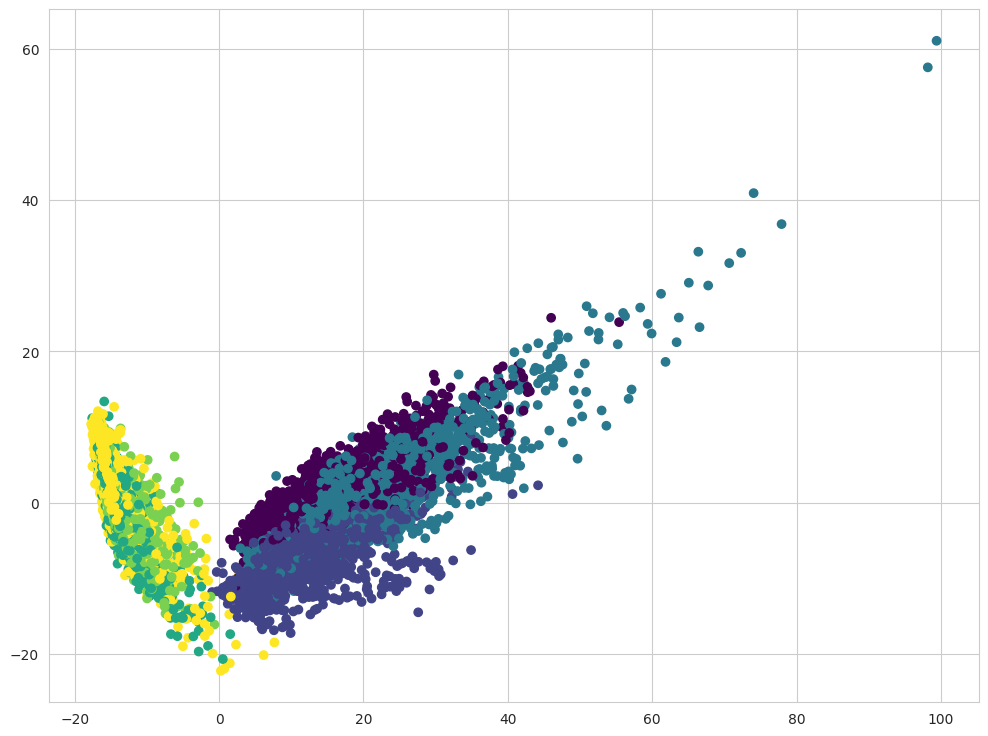

In [17]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- **6 кластеров**

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [25]:
class MyKMeans:
    def __init__(self, n_clusters=6, n_init=100, max_iter=300, random_state=17):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = random_state
        self.centers = None
    
    def fit(self, X):
        np.random.seed(self.random_state)
        best_loss = float('inf')
        for init in range(self.n_init):
            centers = X[np.random.choice(len(X), self.n_clusters, replace=False)]
            for it in range(self.max_iter):
                dists = []
                for c in centers:
                    dists.append(((X - c)**2).sum(axis=1))
                dists = np.array(dists).T
                labels = np.argmin(dists, axis=1)
                new_centers = []
                for i in range(self.n_clusters):
                    new_centers.append(X[labels == i].mean(axis=0))
                new_centers = np.array(new_centers)
                if np.allclose(centers, new_centers):
                    break
                centers = new_centers
            loss = 0
            for i in range(self.n_clusters):
                loss += ((X[labels == i] - centers[i])**2).sum()
            if loss < best_loss:
                best_loss = loss
                best_centers = centers
                best_labels = labels
        self.centers = best_centers
        self.labels_ = best_labels
        self.inertia_ = best_loss
        return self
    
    def predict(self, X):
        dists = []
        for c in self.centers:
            dists.append(((X - c)**2).sum(axis=1))
        dists = np.array(dists).T
        return np.argmin(dists, axis=1)
    
kmeans = KMeans(n_clusters=6, n_init=100, random_state=17)
labels_sklearn = kmeans.fit_predict(X_pca)
my_kmeans = MyKMeans(n_clusters=6, n_init=100, random_state=17)
my_kmeans.fit(X_pca)
labels_my = my_kmeans.predict(X_pca)

print("Inertia sklearn:", kmeans.inertia_)
print("Inertia my:", my_kmeans.inertia_)
print("Difference:", abs(kmeans.inertia_ - my_kmeans.inertia_))

Inertia sklearn: 2003454.8999158172
Inertia my: 2003454.2018751237
Difference: 0.6980406935326755


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

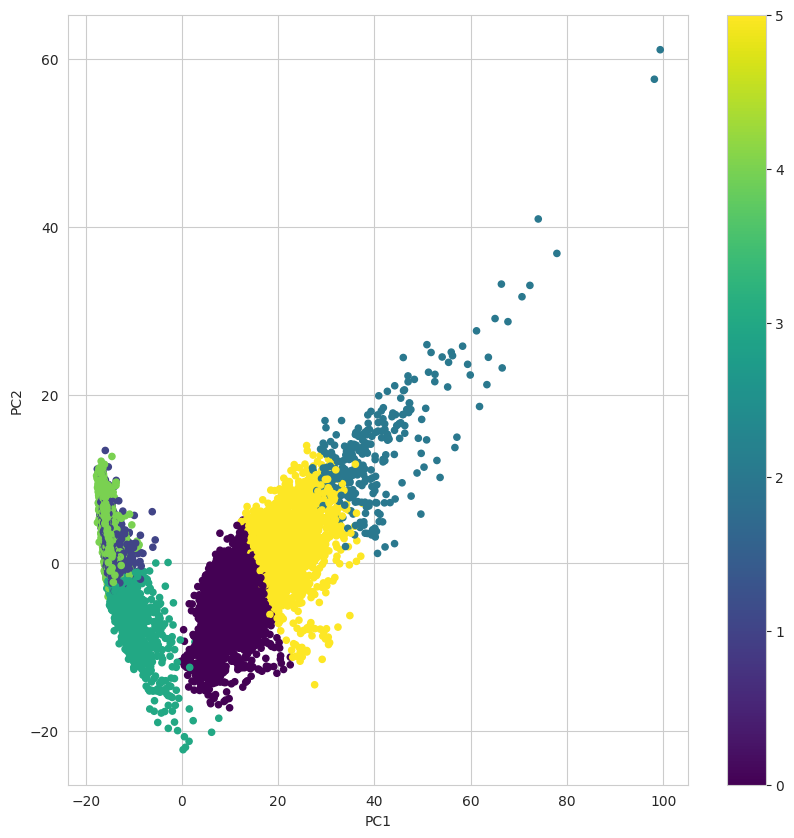

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_my, s=20, cmap='viridis')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [29]:
tab = pd.crosstab(y, labels_my, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,901,0,78,0,0,743,1722
подъем вверх по лестнице,1239,0,5,2,0,298,1544
спуск по лестнице,319,0,196,0,0,891,1406
сидение,1,1235,0,450,91,0,1777
стояние,0,1344,0,562,0,0,1906
лежание,5,52,0,329,1558,0,1944
все,2465,2631,279,1343,1649,1932,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят** (скорее подходят подъем или лежание)

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

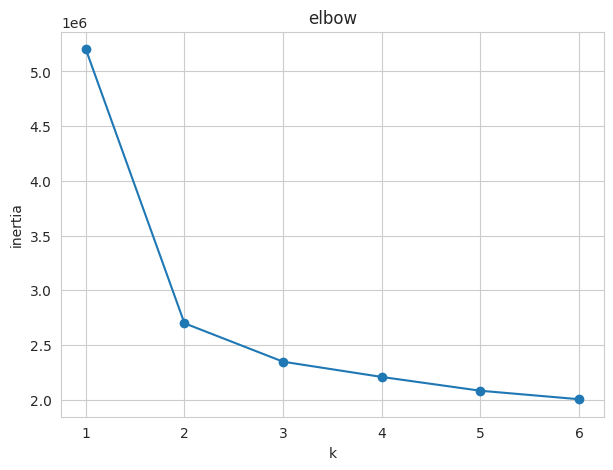

In [37]:
vals = []
ks = list(range(1, n_classes + 1))

i = 0
while i < len(ks):
    model = KMeans(n_clusters=ks[i], n_init=100, random_state=RANDOM_STATE)
    model.fit(X_pca)
    vals.append(model.inertia_)
    i += 1

plt.figure(figsize=(7, 5))
plt.plot(ks, vals, 'o-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('elbow')
plt.show()


**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [38]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [39]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

model_ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward')
pred_ag = model_ag.fit_predict(X_pca)

score_ag = adjusted_rand_score(y, pred_ag)

pred_km = kmeans.predict(X_pca)
score_km = adjusted_rand_score(y, pred_km)

score_ag, score_km


(0.49362763373004886, 0.4198070012602345)

**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [57]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [58]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [59]:
gs = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)
gs.fit(X_train_scaled, y_train)

best_svc = gs.best_estimator_

In [60]:
print("Точность на обучающей выборке (CV):", gs.best_score_)
print("Точность на отложенной тестовой выборке:", best_svc.score(X_test_scaled, y_test))
print("Лучшие параметры:", gs.best_params_)

Точность на обучающей выборке (CV): 0.9381145554917194
Точность на отложенной тестовой выборке: 0.9623345775364778
Лучшие параметры: {'C': 0.1}


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [61]:
y_predicted = best_svc.predict(X_test_scaled)

In [62]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,427,60,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,443,588,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

In [63]:
from sklearn.metrics import precision_score, recall_score

precisions = precision_score(y_test, y_predicted, average=None)
recalls = recall_score(y_test, y_predicted, average=None)

activities = ['ходьба','подъем','спуск','сидение','стояние','лежание']

min_prec_idx = np.argmin(precisions)
min_rec_idx = np.argmin(recalls)

print(f'Хуже всего по точности: {activities[min_prec_idx]} ({precisions[min_prec_idx]:.3f})')
print(f'Хуже всего по полноте: {activities[min_rec_idx]} ({recalls[min_rec_idx]:.3f})')

Хуже всего по точности: стояние (0.879)
Хуже всего по полноте: сидение (0.870)


In [64]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

pca2 = PCA(n_components=0.9, random_state=17)
X_train_pca2 = pca2.fit_transform(X_train_scaled)
X_test_pca2 = pca2.transform(X_test_scaled)

svc2 = LinearSVC(random_state=RANDOM_STATE)
params2 = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid2 = GridSearchCV(svc2, params2, cv=3, n_jobs=-1)
grid2.fit(X_train_pca2, y_train)

print('Best C with PCA:', grid2.best_params_['C'])
print('Best score:', grid2.best_score_)

Best C with PCA: 0.1
Best score: 0.8983982658750974


Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


In [65]:
diff = gs.best_score_ - grid2.best_score_
print(str(round(diff * 100)) + '%')
  

4%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

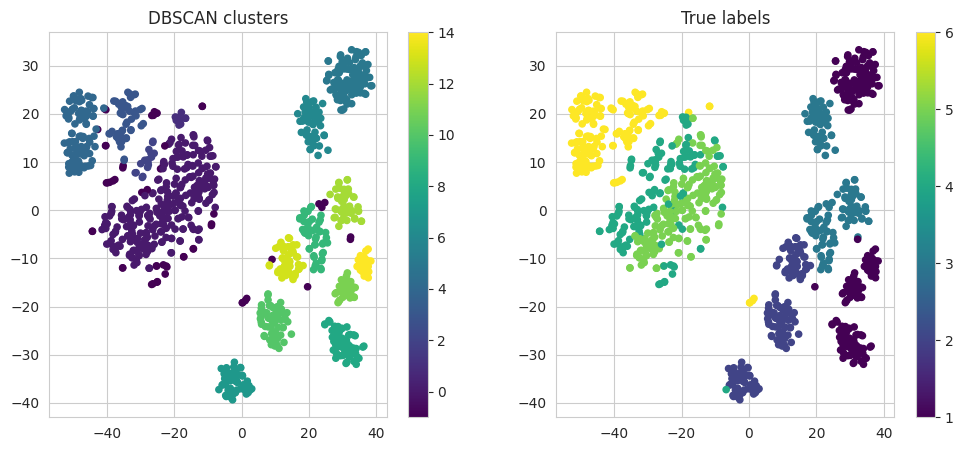

Clusters found: 15
Noise points: 58


In [71]:
tsne = TSNE(n_components=2, random_state=17)
X_tsne = tsne.fit_transform(X_scaled[:1000])
dbscan = DBSCAN(eps=3, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_tsne)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='viridis', s=20)
plt.colorbar()
plt.title('DBSCAN clusters')
plt.subplot(1,2,2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y[:1000], cmap='viridis', s=20)
plt.colorbar()
plt.title('True labels')
plt.show()

print('Clusters found:', len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0))
print('Noise points:', sum(dbscan_labels == -1))